In [ ]:
# INSTALL TORCHMETRICS
!pip install torchmetrics

In [ ]:
# IMPORT
import torch
from torch.utils.data import DataLoader, random_split
from torch import optim, nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchmetrics
from torchmetrics.segmentation import DiceScore

from tqdm import tqdm
import pandas as pd
import os
import seaborn as sns
sns.set_theme()

In [ ]:
# UPLOAD .py FILES WITH MODEL, DATASET LOADER AND UTILS
# UNet_PyTorch_dataset.py, UNet_PyTorch_model.py and UNet_PyTorch_utils.py

from google.colab import files
uploaded = files.upload()

Saving UNet_PyTorch_dataset.py to UNet_PyTorch_dataset.py
Saving UNet_PyTorch_model.py to UNet_PyTorch_model.py
Saving UNet_PyTorch_utils.py to UNet_PyTorch_utils.py


In [ ]:
# IMPORT
from UNet_PyTorch_dataset import MyDataset
from UNet_PyTorch_model import UNet
from UNet_PyTorch_utils import val_image_mask, train_loss_iou_dice_acc_graph

In [ ]:
# CONNECT TO GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# LIST DIRECTORY
! ls

drive	     sample_data	      UNet_PyTorch_model.py
__pycache__  UNet_PyTorch_dataset.py  UNet_PyTorch_utils.py


In [45]:
# SET VARIABLES
ROOT_PATH_DATASET = "/content/drive/MyDrive/dataset" # Path to main dataset folder
TRANSFORM = "transform" # OR "transform_augmentation", but make sure it works on dataset!!
LIMIT = 200 # The nr of images included from dataset, to include all set value to None
BATCH_SIZE = 4
EPOCHS = 100
LEARNING_RATE = 0.001 # For AdamW optimizer learning rate (LR), PyTorch default 0.001
WEIGHT_DECAY = 0.01 # For AdamW optimizer, PyTorch default 0.01
LR_S_STEP_SIZE = 30 # For LR scheduler StepLR, nr of epochs before applying gamma decay
LR_S_GAMMA = 0.1 # For LR scheduler StepLR (LR * gamma = new LR), PyTorch default 0.1
PROBABILITY = 0.5 # Threshold for binary class prediction
DICE_INCLUDE_BACKGROUND = True # TorchMetrics dice score calculation, default True
ROOT_PATH_SAVE = "/content/drive/MyDrive" # OR "/content", path where results folder will be created
CHECKPOINT_PATH = None # Path to checkpoint file with saved model, optimizer and scheduler parameters


# SET DEVICE, RUN ON CUDA IF AVAILABLE
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("\n")
print("#" * 50)
print(f"Running on {device}")
print("#" * 50)
print("\n")


# LOAD DATASET
ROOT_PATH_DATASET = ROOT_PATH_DATASET
TRANSFORM = TRANSFORM
LIMIT = LIMIT
dataset = MyDataset(root_path=ROOT_PATH_DATASET, transform=TRANSFORM, limit=LIMIT)
generator = torch.Generator().manual_seed(25)

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=generator)


LEARNING_RATE = LEARNING_RATE
BATCH_SIZE = BATCH_SIZE

train_dataloader = DataLoader(dataset=train_dataset,
                              pin_memory=False,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                              pin_memory=False,
                              batch_size=BATCH_SIZE,
                              shuffle=True)


# SET MODEL COST FUNCTION, OPTIMIZER AND LEARNING RATE SCHEDULER
in_channels = 3
num_classes = 1

model = UNet(in_channels, num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = lr_scheduler.StepLR(optimizer, step_size=LR_S_STEP_SIZE, gamma=LR_S_GAMMA)

if CHECKPOINT_PATH != None:
  checkpoint = torch.load(CHECKPOINT_PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

model_name = model.__class__.__name__
optimizer_name = optimizer.__class__.__name__
criterion_name = criterion.__class__.__name__
scheduler_name = scheduler.__class__.__name__



##################################################
Running on cuda
##################################################




EPOCHS:   0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: DiceScore metric currently defaults to `average=micro`, but will change to`average=macro` in the v1.9 release. If you've explicitly set this parameter, you can ignore this warning.
  warnings.warn(*args, **kwargs)


--------------------------------------------------
Beginning of epoch 1
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [01:07<00:00,  1.68s/it]


End of training part of epoch 1
-----


BATCH VAL: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


End of validation part of epoch 1
--------------------------------------------------
End of epoch 1
--------------------------------------------------
Training Loss EPOCH 1: 0.3327
Training IoU EPOCH 1: 0.7491
--------------------------------------------------
Validation Loss EPOCH 1: 0.3325
Validation IoU EPOCH 1: 0.5910
--------------------------------------------------


EPOCHS:   3%|▎         | 1/30 [01:30<43:48, 90.62s/it]

--------------------------------------------------
Beginning of epoch 2
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:38<00:00,  1.03it/s]


End of training part of epoch 2
-----


BATCH VAL: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


End of validation part of epoch 2
--------------------------------------------------
End of epoch 2
--------------------------------------------------
Training Loss EPOCH 2: 0.2066
Training IoU EPOCH 2: 0.9330
--------------------------------------------------
Validation Loss EPOCH 2: 0.1961
Validation IoU EPOCH 2: 0.9504
--------------------------------------------------


EPOCHS:   7%|▋         | 2/30 [02:16<30:01, 64.36s/it]

--------------------------------------------------
Beginning of epoch 3
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]


End of training part of epoch 3
-----


BATCH VAL: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


End of validation part of epoch 3
--------------------------------------------------
End of epoch 3
--------------------------------------------------
Training Loss EPOCH 3: 0.1813
Training IoU EPOCH 3: 0.9478
--------------------------------------------------
Validation Loss EPOCH 3: 0.1782
Validation IoU EPOCH 3: 0.9354
--------------------------------------------------


EPOCHS:  10%|█         | 3/30 [03:03<25:27, 56.59s/it]

--------------------------------------------------
Beginning of epoch 4
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:39<00:00,  1.02it/s]


End of training part of epoch 4
-----


BATCH VAL: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


End of validation part of epoch 4
--------------------------------------------------
End of epoch 4
--------------------------------------------------
Training Loss EPOCH 4: 0.1635
Training IoU EPOCH 4: 0.9546
--------------------------------------------------
Validation Loss EPOCH 4: 0.1615
Validation IoU EPOCH 4: 0.9535
--------------------------------------------------


EPOCHS:  13%|█▎        | 4/30 [03:50<22:47, 52.59s/it]

--------------------------------------------------
Beginning of epoch 5
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]


End of training part of epoch 5
-----


BATCH VAL: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


End of validation part of epoch 5
--------------------------------------------------
End of epoch 5
--------------------------------------------------
Training Loss EPOCH 5: 0.1538
Training IoU EPOCH 5: 0.9473
--------------------------------------------------
Validation Loss EPOCH 5: 1.0983
Validation IoU EPOCH 5: 0.3473
--------------------------------------------------


EPOCHS:  17%|█▋        | 5/30 [04:37<21:05, 50.61s/it]

--------------------------------------------------
Beginning of epoch 6
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:39<00:00,  1.02it/s]


End of training part of epoch 6
-----


BATCH VAL: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


End of validation part of epoch 6
--------------------------------------------------
End of epoch 6
--------------------------------------------------
Training Loss EPOCH 6: 0.1416
Training IoU EPOCH 6: 0.9494
--------------------------------------------------
Validation Loss EPOCH 6: 0.1367
Validation IoU EPOCH 6: 0.9623
--------------------------------------------------


EPOCHS:  20%|██        | 6/30 [05:24<19:41, 49.24s/it]

--------------------------------------------------
Beginning of epoch 7
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]


End of training part of epoch 7
-----


BATCH VAL: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


End of validation part of epoch 7
--------------------------------------------------
End of epoch 7
--------------------------------------------------
Training Loss EPOCH 7: 0.1259
Training IoU EPOCH 7: 0.9628
--------------------------------------------------
Validation Loss EPOCH 7: 0.1180
Validation IoU EPOCH 7: 0.9642
--------------------------------------------------


EPOCHS:  23%|██▎       | 7/30 [06:10<18:33, 48.42s/it]

--------------------------------------------------
Beginning of epoch 8
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:39<00:00,  1.00it/s]


End of training part of epoch 8
-----


BATCH VAL: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


End of validation part of epoch 8
--------------------------------------------------
End of epoch 8
--------------------------------------------------
Training Loss EPOCH 8: 0.1160
Training IoU EPOCH 8: 0.9639
--------------------------------------------------
Validation Loss EPOCH 8: 0.1114
Validation IoU EPOCH 8: 0.9639
--------------------------------------------------


EPOCHS:  27%|██▋       | 8/30 [06:58<17:38, 48.12s/it]

--------------------------------------------------
Beginning of epoch 9
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]


End of training part of epoch 9
-----


BATCH VAL: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


End of validation part of epoch 9
--------------------------------------------------
End of epoch 9
--------------------------------------------------
Training Loss EPOCH 9: 0.1060
Training IoU EPOCH 9: 0.9681
--------------------------------------------------
Validation Loss EPOCH 9: 0.1038
Validation IoU EPOCH 9: 0.9659
--------------------------------------------------


EPOCHS:  30%|███       | 9/30 [07:45<16:41, 47.71s/it]

--------------------------------------------------
Beginning of epoch 10
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]


End of training part of epoch 10
-----


BATCH VAL: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


End of validation part of epoch 10
--------------------------------------------------
End of epoch 10
--------------------------------------------------
Training Loss EPOCH 10: 0.0977
Training IoU EPOCH 10: 0.9703
--------------------------------------------------
Validation Loss EPOCH 10: 0.0956
Validation IoU EPOCH 10: 0.9638
--------------------------------------------------


EPOCHS:  33%|███▎      | 10/30 [08:33<15:57, 47.89s/it]

--------------------------------------------------
Beginning of epoch 11
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


End of training part of epoch 11
-----


BATCH VAL: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


End of validation part of epoch 11
--------------------------------------------------
End of epoch 11
--------------------------------------------------
Training Loss EPOCH 11: 0.0927
Training IoU EPOCH 11: 0.9714
--------------------------------------------------
Validation Loss EPOCH 11: 0.0936
Validation IoU EPOCH 11: 0.9704
--------------------------------------------------


EPOCHS:  37%|███▋      | 11/30 [09:22<15:17, 48.27s/it]

--------------------------------------------------
Beginning of epoch 12
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:44<00:00,  1.12s/it]


End of training part of epoch 12
-----


BATCH VAL: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


End of validation part of epoch 12
--------------------------------------------------
End of epoch 12
--------------------------------------------------
Training Loss EPOCH 12: 0.0916
Training IoU EPOCH 12: 0.9727
--------------------------------------------------
Validation Loss EPOCH 12: 0.0924
Validation IoU EPOCH 12: 0.9726
--------------------------------------------------


EPOCHS:  40%|████      | 12/30 [10:15<14:53, 49.66s/it]

--------------------------------------------------
Beginning of epoch 13
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:44<00:00,  1.12s/it]


End of training part of epoch 13
-----


BATCH VAL: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


End of validation part of epoch 13
--------------------------------------------------
End of epoch 13
--------------------------------------------------
Training Loss EPOCH 13: 0.0906
Training IoU EPOCH 13: 0.9734
--------------------------------------------------
Validation Loss EPOCH 13: 0.0905
Validation IoU EPOCH 13: 0.9712
--------------------------------------------------


EPOCHS:  43%|████▎     | 13/30 [11:07<14:19, 50.56s/it]

--------------------------------------------------
Beginning of epoch 14
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:49<00:00,  1.23s/it]


End of training part of epoch 14
-----


BATCH VAL: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


End of validation part of epoch 14
--------------------------------------------------
End of epoch 14
--------------------------------------------------
Training Loss EPOCH 14: 0.0900
Training IoU EPOCH 14: 0.9732
--------------------------------------------------
Validation Loss EPOCH 14: 0.0907
Validation IoU EPOCH 14: 0.9716
--------------------------------------------------


EPOCHS:  47%|████▋     | 14/30 [12:05<14:01, 52.60s/it]

--------------------------------------------------
Beginning of epoch 15
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:46<00:00,  1.16s/it]


End of training part of epoch 15
-----


BATCH VAL: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


End of validation part of epoch 15
--------------------------------------------------
End of epoch 15
--------------------------------------------------
Training Loss EPOCH 15: 0.0892
Training IoU EPOCH 15: 0.9737
--------------------------------------------------
Validation Loss EPOCH 15: 0.0900
Validation IoU EPOCH 15: 0.9724
--------------------------------------------------


EPOCHS:  50%|█████     | 15/30 [12:58<13:13, 52.92s/it]

--------------------------------------------------
Beginning of epoch 16
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:48<00:00,  1.22s/it]


End of training part of epoch 16
-----


BATCH VAL: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


End of validation part of epoch 16
--------------------------------------------------
End of epoch 16
--------------------------------------------------
Training Loss EPOCH 16: 0.0884
Training IoU EPOCH 16: 0.9740
--------------------------------------------------
Validation Loss EPOCH 16: 0.0882
Validation IoU EPOCH 16: 0.9705
--------------------------------------------------


EPOCHS:  53%|█████▎    | 16/30 [13:54<12:33, 53.80s/it]

--------------------------------------------------
Beginning of epoch 17
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:44<00:00,  1.12s/it]


End of training part of epoch 17
-----


BATCH VAL: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


End of validation part of epoch 17
--------------------------------------------------
End of epoch 17
--------------------------------------------------
Training Loss EPOCH 17: 0.0875
Training IoU EPOCH 17: 0.9739
--------------------------------------------------
Validation Loss EPOCH 17: 0.0873
Validation IoU EPOCH 17: 0.9714
--------------------------------------------------


EPOCHS:  57%|█████▋    | 17/30 [14:48<11:40, 53.88s/it]

--------------------------------------------------
Beginning of epoch 18
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:48<00:00,  1.21s/it]


End of training part of epoch 18
-----


BATCH VAL: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


End of validation part of epoch 18
--------------------------------------------------
End of epoch 18
--------------------------------------------------
Training Loss EPOCH 18: 0.0869
Training IoU EPOCH 18: 0.9739
--------------------------------------------------
Validation Loss EPOCH 18: 0.0869
Validation IoU EPOCH 18: 0.9713
--------------------------------------------------


EPOCHS:  60%|██████    | 18/30 [15:54<11:29, 57.42s/it]

--------------------------------------------------
Beginning of epoch 19
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:50<00:00,  1.26s/it]


End of training part of epoch 19
-----


BATCH VAL: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


End of validation part of epoch 19
--------------------------------------------------
End of epoch 19
--------------------------------------------------
Training Loss EPOCH 19: 0.0859
Training IoU EPOCH 19: 0.9743
--------------------------------------------------
Validation Loss EPOCH 19: 0.0877
Validation IoU EPOCH 19: 0.9725
--------------------------------------------------


EPOCHS:  63%|██████▎   | 19/30 [16:52<10:33, 57.62s/it]

--------------------------------------------------
Beginning of epoch 20
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


End of training part of epoch 20
-----


BATCH VAL: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


End of validation part of epoch 20
--------------------------------------------------
End of epoch 20
--------------------------------------------------
Training Loss EPOCH 20: 0.0854
Training IoU EPOCH 20: 0.9743
--------------------------------------------------
Validation Loss EPOCH 20: 0.0854
Validation IoU EPOCH 20: 0.9716
--------------------------------------------------


EPOCHS:  67%|██████▋   | 20/30 [17:40<09:05, 54.59s/it]

--------------------------------------------------
Beginning of epoch 21
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:42<00:00,  1.05s/it]


End of training part of epoch 21
-----


BATCH VAL: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


End of validation part of epoch 21
--------------------------------------------------
End of epoch 21
--------------------------------------------------
Training Loss EPOCH 21: 0.0847
Training IoU EPOCH 21: 0.9743
--------------------------------------------------
Validation Loss EPOCH 21: 0.0853
Validation IoU EPOCH 21: 0.9725
--------------------------------------------------


EPOCHS:  70%|███████   | 21/30 [18:30<08:00, 53.35s/it]

--------------------------------------------------
Beginning of epoch 22
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


End of training part of epoch 22
-----


BATCH VAL: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


End of validation part of epoch 22
--------------------------------------------------
End of epoch 22
--------------------------------------------------
Training Loss EPOCH 22: 0.0846
Training IoU EPOCH 22: 0.9748
--------------------------------------------------
Validation Loss EPOCH 22: 0.0856
Validation IoU EPOCH 22: 0.9724
--------------------------------------------------


EPOCHS:  73%|███████▎  | 22/30 [19:18<06:53, 51.71s/it]

--------------------------------------------------
Beginning of epoch 23
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


End of training part of epoch 23
-----


BATCH VAL: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


End of validation part of epoch 23
--------------------------------------------------
End of epoch 23
--------------------------------------------------
Training Loss EPOCH 23: 0.0847
Training IoU EPOCH 23: 0.9747
--------------------------------------------------
Validation Loss EPOCH 23: 0.0851
Validation IoU EPOCH 23: 0.9727
--------------------------------------------------


EPOCHS:  77%|███████▋  | 23/30 [20:06<05:54, 50.70s/it]

--------------------------------------------------
Beginning of epoch 24
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


End of training part of epoch 24
-----


BATCH VAL: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


End of validation part of epoch 24
--------------------------------------------------
End of epoch 24
--------------------------------------------------
Training Loss EPOCH 24: 0.0843
Training IoU EPOCH 24: 0.9749
--------------------------------------------------
Validation Loss EPOCH 24: 0.0858
Validation IoU EPOCH 24: 0.9719
--------------------------------------------------


EPOCHS:  80%|████████  | 24/30 [20:58<05:06, 51.12s/it]

--------------------------------------------------
Beginning of epoch 25
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:41<00:00,  1.04s/it]


End of training part of epoch 25
-----


BATCH VAL: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


End of validation part of epoch 25
--------------------------------------------------
End of epoch 25
--------------------------------------------------
Training Loss EPOCH 25: 0.0846
Training IoU EPOCH 25: 0.9745
--------------------------------------------------
Validation Loss EPOCH 25: 0.0864
Validation IoU EPOCH 25: 0.9712
--------------------------------------------------


EPOCHS:  83%|████████▎ | 25/30 [21:48<04:13, 50.64s/it]

--------------------------------------------------
Beginning of epoch 26
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:39<00:00,  1.02it/s]


End of training part of epoch 26
-----


BATCH VAL: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


End of validation part of epoch 26
--------------------------------------------------
End of epoch 26
--------------------------------------------------
Training Loss EPOCH 26: 0.0843
Training IoU EPOCH 26: 0.9750
--------------------------------------------------
Validation Loss EPOCH 26: 0.0850
Validation IoU EPOCH 26: 0.9724
--------------------------------------------------


EPOCHS:  87%|████████▋ | 26/30 [22:35<03:18, 49.70s/it]

--------------------------------------------------
Beginning of epoch 27
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]


End of training part of epoch 27
-----


BATCH VAL: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


End of validation part of epoch 27
--------------------------------------------------
End of epoch 27
--------------------------------------------------
Training Loss EPOCH 27: 0.0841
Training IoU EPOCH 27: 0.9749
--------------------------------------------------
Validation Loss EPOCH 27: 0.0847
Validation IoU EPOCH 27: 0.9729
--------------------------------------------------


EPOCHS:  90%|█████████ | 27/30 [23:25<02:28, 49.54s/it]

--------------------------------------------------
Beginning of epoch 28
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


End of training part of epoch 28
-----


BATCH VAL: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


End of validation part of epoch 28
--------------------------------------------------
End of epoch 28
--------------------------------------------------
Training Loss EPOCH 28: 0.0842
Training IoU EPOCH 28: 0.9747
--------------------------------------------------
Validation Loss EPOCH 28: 0.0859
Validation IoU EPOCH 28: 0.9717
--------------------------------------------------


EPOCHS:  93%|█████████▎| 28/30 [24:15<01:39, 49.91s/it]

--------------------------------------------------
Beginning of epoch 29
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:55<00:00,  1.38s/it]


End of training part of epoch 29
-----


BATCH VAL: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


End of validation part of epoch 29
--------------------------------------------------
End of epoch 29
--------------------------------------------------
Training Loss EPOCH 29: 0.0841
Training IoU EPOCH 29: 0.9747
--------------------------------------------------
Validation Loss EPOCH 29: 0.0848
Validation IoU EPOCH 29: 0.9726
--------------------------------------------------


EPOCHS:  97%|█████████▋| 29/30 [25:21<00:54, 54.70s/it]

--------------------------------------------------
Beginning of epoch 30
--------------------------------------------------


BATCH TRAIN: 100%|██████████| 40/40 [00:47<00:00,  1.18s/it]


End of training part of epoch 30
-----


BATCH VAL: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


End of validation part of epoch 30
--------------------------------------------------
End of epoch 30
--------------------------------------------------
Training Loss EPOCH 30: 0.0839
Training IoU EPOCH 30: 0.9751
--------------------------------------------------
Validation Loss EPOCH 30: 0.0847
Validation IoU EPOCH 30: 0.9729
--------------------------------------------------


EPOCHS: 100%|██████████| 30/30 [26:20<00:00, 52.67s/it]


-----
    Epoch  Train loss  Val loss  Train IoU   Val IoU  Train dice  Val dice  \
0       1    0.332670  0.332521   0.749061  0.591049    0.832902  0.732784   
1       2    0.206647  0.196111   0.933038  0.950397    0.964986  0.974080   
2       3    0.181251  0.178235   0.947797  0.935426    0.972761  0.965185   
3       4    0.163481  0.161496   0.954614  0.953457    0.976542  0.975076   
4       5    0.153755  1.098299   0.947258  0.347281    0.972179  0.515151   
5       6    0.141580  0.136731   0.949422  0.962339    0.973733  0.980415   
6       7    0.125901  0.118034   0.962765  0.964150    0.980799  0.981584   
7       8    0.116014  0.111389   0.963909  0.963892    0.981442  0.981473   
8       9    0.106008  0.103827   0.968124  0.965905    0.983608  0.982246   
9      10    0.097733  0.095613   0.970342  0.963827    0.984791  0.981490   
10     11    0.092736  0.093566   0.971435  0.970439    0.985416  0.984731   
11     12    0.091605  0.092429   0.972688  0.972608    0.

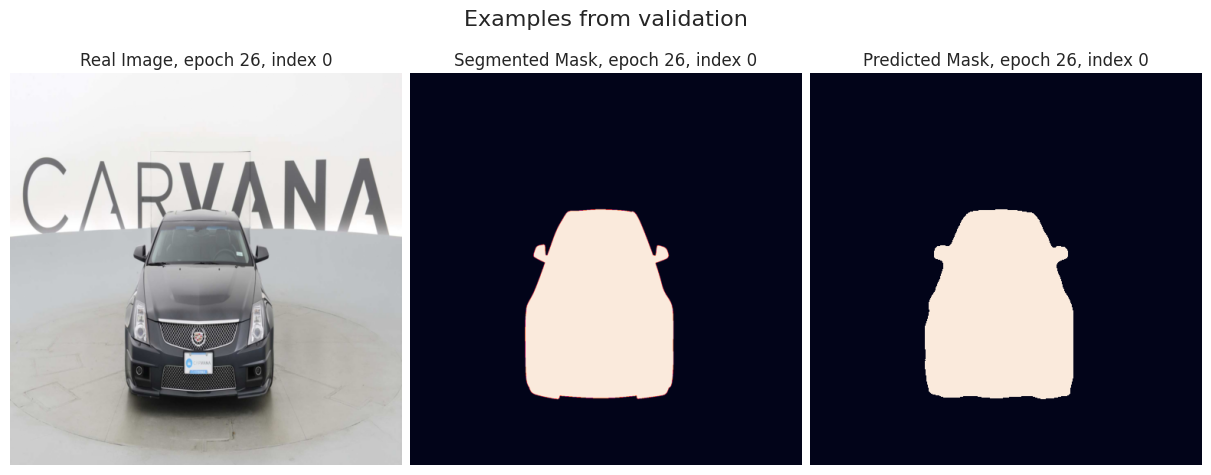

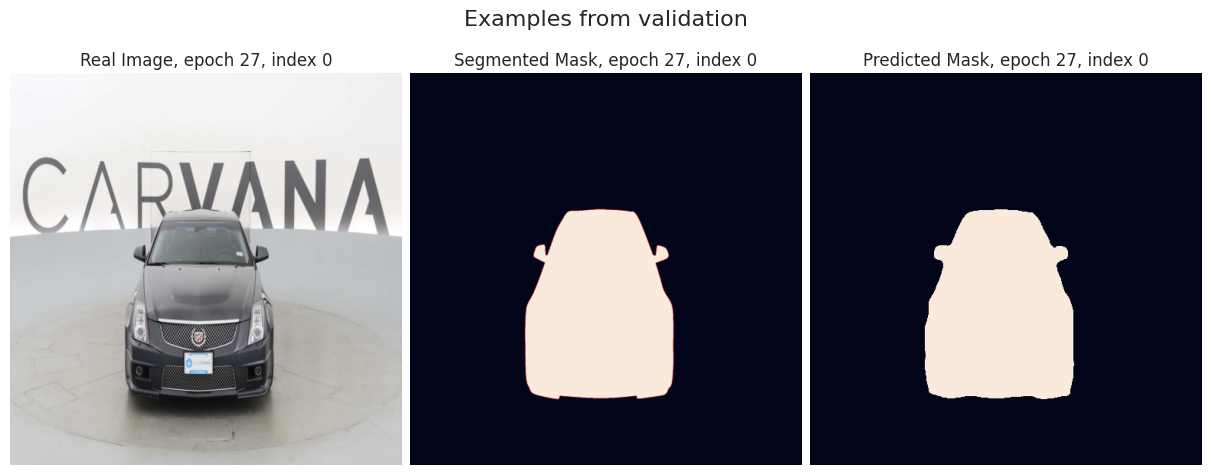

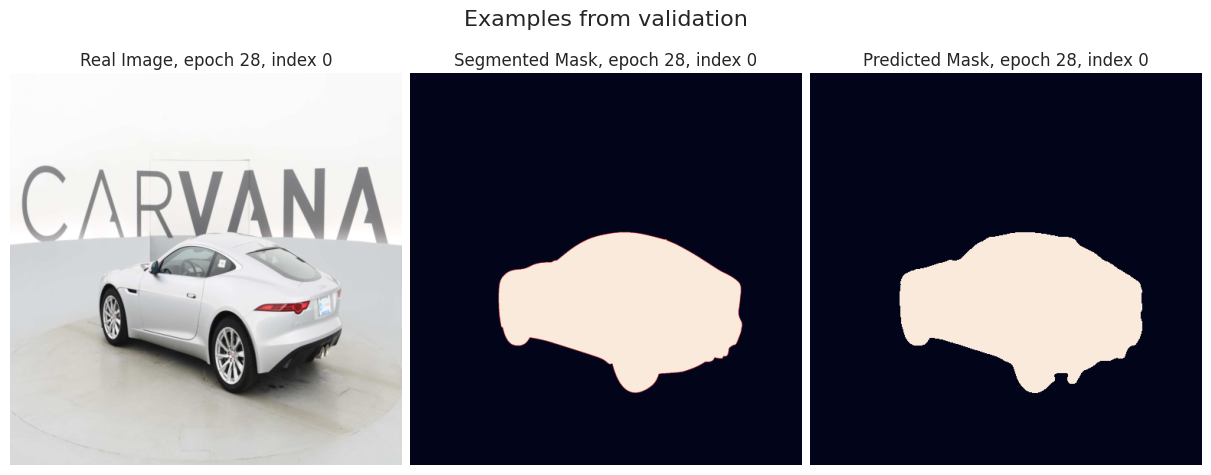

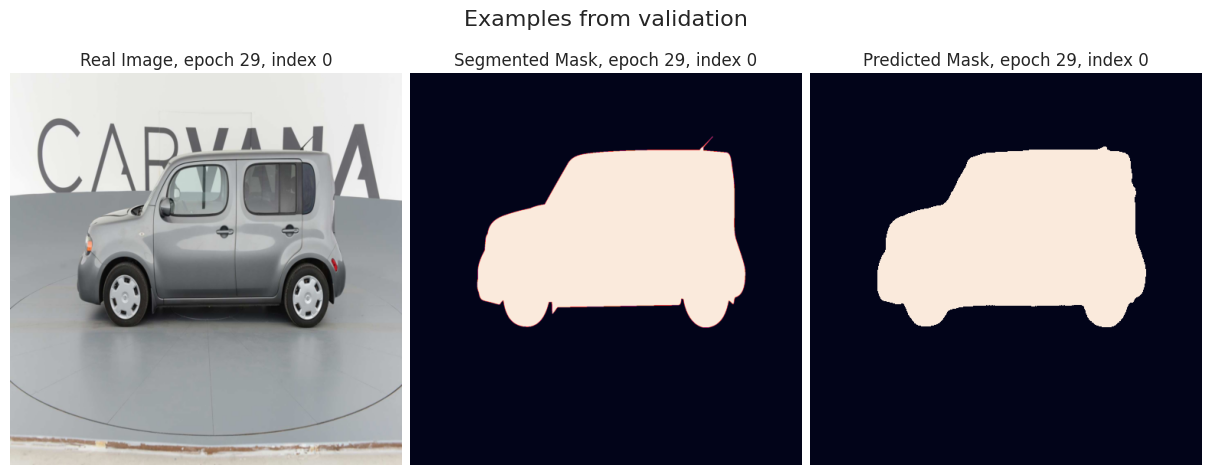

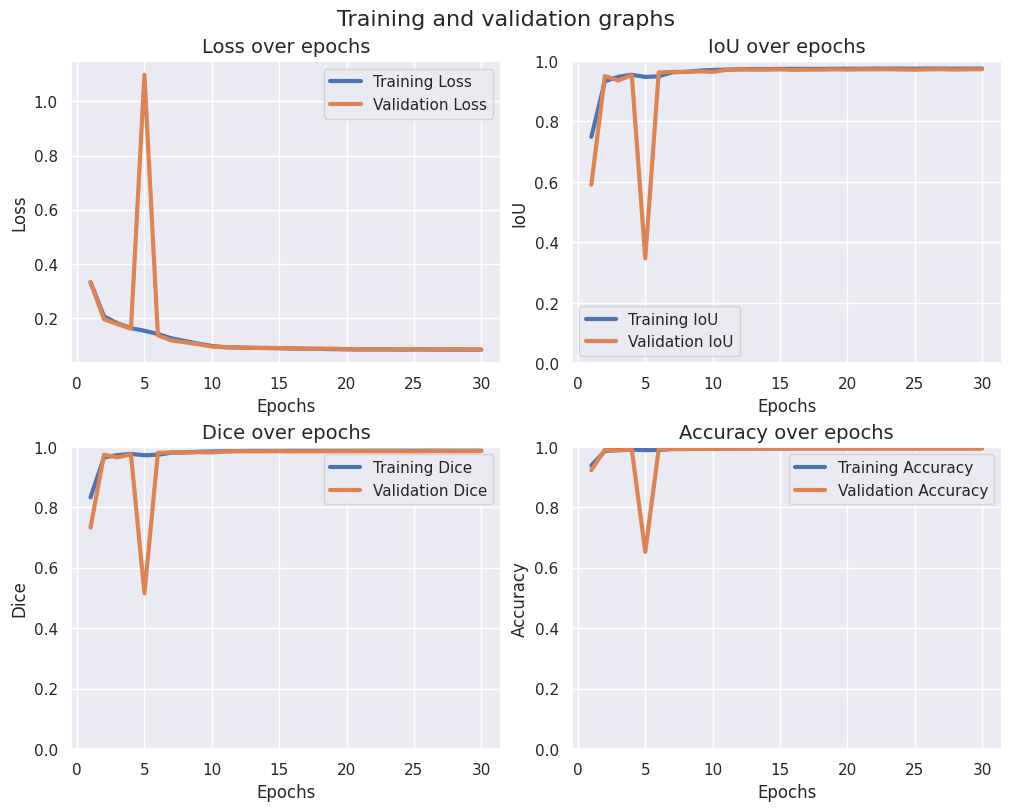

In [46]:
# SAVE RESULTS
ROOT_PATH_SAVE = ROOT_PATH_SAVE
save_directory = "UNet_training_results"
save_path = os.path.join(ROOT_PATH_SAVE, save_directory)

if not os.path.exists(save_path):
    os.mkdir(save_path)
else:
    x = 1
    while os.path.exists(save_path):
        new_save_directory = (f"{save_directory}_{x + 1}")
        save_path = os.path.join(ROOT_PATH_SAVE, new_save_directory)
        x += 1
    os.mkdir(save_path)


# TRAIN AND EVALUATE
EPOCHS = EPOCHS
train_losses = []
train_dices = []
train_ious = []
train_dices = []
train_accs = []
val_losses = []
val_ious = []
val_dices = []
val_accs = []
lr_updates = []

for epoch in tqdm(range(EPOCHS), "EPOCHS"):
    model.train()
    train_loss_sum = 0
    train_iou_sum = 0
    train_dice_sum = 0
    train_acc_sum = 0
    nr_of_train_loss_items = 0

    jaccardindex = torchmetrics.JaccardIndex(task='binary').to(device)
    dice_segmentation = DiceScore(num_classes=1, include_background=DICE_INCLUDE_BACKGROUND).to(device)
    accuracy = torchmetrics.Accuracy(task='binary').to(device)

    print("-" * 50)
    print(f"Beginning of epoch {epoch + 1}")
    print("-" * 50)

    for idx, img_mask in enumerate(tqdm(train_dataloader, "BATCH TRAIN", position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        mask_pred = model(img)
        optimizer.zero_grad()

        loss = criterion(mask_pred, mask)

        prediction = torch.sigmoid(mask_pred)
        prediction[prediction < PROBABILITY] = 0
        prediction[prediction >= PROBABILITY] = 1

        prediction_int = prediction.long()
        mask_int = mask.long()

        iou = jaccardindex(prediction_int, mask_int)
        dice = dice_segmentation(prediction_int, mask_int)
        acc = accuracy(prediction_int, mask_int)

        train_loss_sum += loss.item()
        train_iou_sum += iou.item()
        train_dice_sum += dice.item()
        train_acc_sum += acc.item()
        nr_of_train_loss_items += 1

        loss.backward()
        optimizer.step()

    scheduler.step()
    updated_lr = scheduler.get_last_lr()
    lr_updates.append(updated_lr)

    train_loss = train_loss_sum / len(train_dataloader)
    train_iou = train_iou_sum / len(train_dataloader)
    train_dice = train_dice_sum / len(train_dataloader)
    train_acc = train_acc_sum / len(train_dataloader)

    train_losses.append(train_loss)
    train_ious.append(train_iou)
    train_dices.append(train_dice)
    train_accs.append(train_acc)

    print(f"End of training part of epoch {epoch + 1}")
    print("-" * 5)


    model.eval()
    val_loss_sum = 0
    val_iou_sum = 0
    val_dice_sum = 0
    val_acc_sum = 0
    nr_of_val_loss_items = 0
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader, "BATCH VAL", position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            mask_pred = model(img)
            loss = criterion(mask_pred, mask)

            prediction = torch.sigmoid(mask_pred)
            prediction[prediction < PROBABILITY] = 0
            prediction[prediction >= PROBABILITY] = 1

            prediction_int = prediction.long()
            mask_int = mask.long()

            iou = jaccardindex(prediction_int, mask_int)
            dice = dice_segmentation(prediction_int, mask_int)
            acc = accuracy(prediction_int, mask_int)

            val_loss_sum += loss.item()
            val_iou_sum += iou.item()
            val_dice_sum += dice.item()
            val_acc_sum += acc.item()
            nr_of_val_loss_items += 1

            # SAVE IMAGES FOR SOME OF THE PREDICTIONS
            if idx == 0 and epoch > EPOCHS - 5:
                val_image_mask(save_path, epoch, idx, img, mask, prediction)

        val_loss = val_loss_sum / len(val_dataloader)
        val_iou = val_iou_sum / len(val_dataloader)
        val_dice = val_dice_sum / len(val_dataloader)
        val_acc = val_acc_sum / len(val_dataloader)

        val_losses.append(val_loss)
        val_ious.append(val_iou)
        val_dices.append(val_dice)
        val_accs.append(val_acc)

        print(f"End of validation part of epoch {epoch + 1}")


    print("-" * 50)
    print(f"End of epoch {epoch + 1}")
    print("-" * 50)
    print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Training IoU EPOCH {epoch + 1}: {train_iou:.4f}")
    print("-" * 50)
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(f"Validation IoU EPOCH {epoch + 1}: {val_iou:.4f}")
    print("-" * 50)


    checkpoint = {'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'scheduler_state_dict': scheduler.state_dict()}
    torch.save(checkpoint, (os.path.join(save_path, f"checkpoint_{epoch + 1}.pth")))


# PANDAS DATAFRAME WITH TRAINING RESULTS
epochs_list = list(range(1, EPOCHS + 1))
lists = [epochs_list, train_losses, val_losses, train_ious, val_ious,
         train_dices, val_dices, train_accs, val_accs, lr_updates]
titles = ["Epoch", "Train loss", "Val loss", "Train IoU", "Val IoU",
          "Train dice", "Val dice", "Train acc", "Val acc", "Updated LR"]
training_results_dictionary = {"Epoch": epochs_list, "Train loss": train_losses,
                               "Val loss": val_losses, "Train IoU": train_ious,
                               "Val IoU": val_ious, "Train dice": train_dices,
                               "Val dice": val_dices, "Train acc": train_accs,
                               "Val acc": val_accs, "Updated LR": lr_updates}
df = pd.DataFrame(training_results_dictionary)
df.to_csv((os.path.join(save_path, "training_dataframe.csv")), index=False)
print("-" * 5)
print(df)
print("-" * 50)


# PANDAS DATAFRAME WITH GENERAL INFO
info_names = ["Model", "Criterion", "Optimizer", "Weight decay", "LR scheduler", "LR start", "LR step size",
              "LR gamma", "Input channels", "Number of classes", "Length dataset", "Training images",
              "Validation images", "Limit", "Batch size", "Epochs", "Probability", "Dice include background"]
info_items = [model_name, criterion_name, optimizer_name, WEIGHT_DECAY, scheduler_name, LEARNING_RATE,
              LR_S_STEP_SIZE, LR_S_GAMMA, in_channels, num_classes, len(dataset), len(train_dataset),
              len(val_dataset), LIMIT, BATCH_SIZE, EPOCHS, PROBABILITY, DICE_INCLUDE_BACKGROUND]

info_dict = {"Item": info_names, "Info": info_items}
info_df = pd.DataFrame(info_dict)
info_df.to_csv((os.path.join(save_path, "training_info.csv")), index=False)


# GRAPH SHOWING TRAINING AND VALIDATION LOSS AND DICE
loss_iou_dice_acc_graph = train_loss_iou_dice_acc_graph(save_path, epochs_list, train_losses, val_losses,
                                  train_ious, val_ious, train_dices, val_dices, train_accs, val_accs)


torch.cuda.empty_cache()